In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import random

In [2]:
df = pd.read_csv('auto_insurance_csv.csv')
df = df.drop(['_c39','Unnamed: 0'], axis = 1)
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df['policy_csl'] = df.policy_csl.fillna("MISSING")
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)
df['umbrella_limit'] = df.umbrella_limit.astype(str)
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
  if (umb != '0.0') & (umb != '9999'):
    df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other', regex = True)
    
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['age'] = df.age.fillna(9999)
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium', 'incident_date'], axis = 1)
required_columns = ['policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']
df1 = df[required_columns]

In [3]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df1[col] = df1[col].astype('object')

columns_to_encode = []
for col in df1.columns:
  if df1[col].dtype == 'object':
    columns_to_encode.append(col)

columns_to_encode

C:\Users\kemal\AppData\Local\Temp/ipykernel_16720/3419747452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = df1[col].astype('object')


['policy_state',
 'policy_csl',
 'umbrella_limit',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'insured_relationship',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'incident_location',
 'property_damage',
 'police_report_available',
 'auto_make',
 'auto_model',
 'location_check',
 'age_group',
 'months_as_customer_groups',
 'policy_annual_premium_groups',
 'policy_deductable_group']

In [4]:
df1_encoded = pd.get_dummies(df1, columns = columns_to_encode)

In [5]:
df1_encoded

,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,fraud_reported,...,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
0,466132,53300,0,5,1,1,2,71610,2004,1,...,0,0,0,0,1,0,0,0,0,1
1,468176,0,0,8,1,0,0,5070,2007,1,...,0,0,0,0,1,0,0,0,1,0
2,430632,35100,0,7,3,2,3,34650,2007,0,...,0,0,0,0,1,0,0,0,1,0
3,608117,48900,-62400,5,1,1,2,63400,2014,1,...,0,0,0,0,1,0,0,0,1,0
4,610706,66000,-46000,20,1,0,1,6500,2009,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,431289,0,0,20,1,0,1,87200,2006,0,...,0,0,0,0,1,0,0,0,0,1
996,608177,70900,0,23,1,2,3,108480,2015,0,...,0,0,0,0,1,0,0,0,0,1
997,442797,35100,0,4,3,2,3,67500,1996,0,...,0,0,0,0,1,0,0,1,0,0
998,441714,0,0,2,1,0,1,46980,1998,0,...,1,0,0,0,1,0,0,0,1,0


In [6]:
cols = df1_encoded.columns
num_cols = df1_encoded._get_numeric_data().columns
list(set(cols) - set(num_cols))

[]

C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

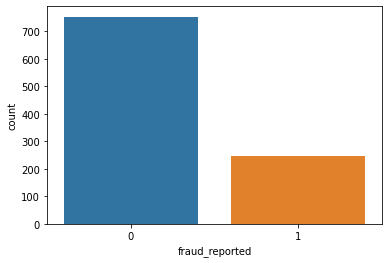

In [7]:
sns.countplot(df1_encoded['fraud_reported'])

In [8]:
features = []
for col in df1_encoded.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = df1_encoded[features]
y = df1_encoded[target]

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [10]:
oversample = SMOTE(random_state=13)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 7)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, y_train = X_over, y_over

C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

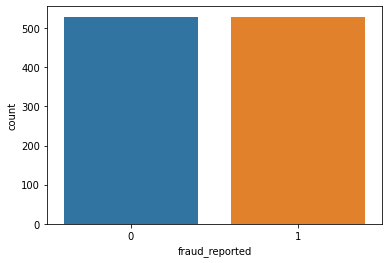

In [11]:
sns.countplot(y_train)

79.0
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       224
           1       0.81      0.22      0.35        76

    accuracy                           0.79       300
   macro avg       0.80      0.60      0.61       300
weighted avg       0.79      0.79      0.74       300



<AxesSubplot:>

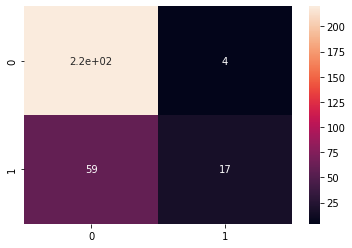

In [14]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
preds = lr.predict(X_test)

score = lr.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

78.33333333333333

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       224
           1       0.69      0.26      0.38        76

    accuracy                           0.78       300
   macro avg       0.74      0.61      0.62       300
weighted avg       0.77      0.78      0.75       300



<AxesSubplot:>

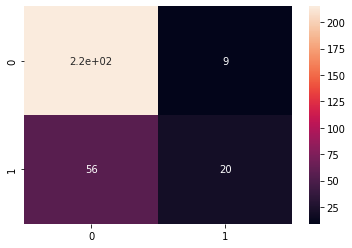

In [15]:
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

In [18]:
from sklearn.model_selection import RandomizedSearchCV
#(estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=3, random_state=13, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [1, 500, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [1, 15, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 15, 30, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1, 500, 1000]},
                   random_state=13, verbose=3)

In [17]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 15,
 'bootstrap': False}

80.66666666666666

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       224
           1       0.62      0.59      0.61        76

    accuracy                           0.81       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.80      0.81      0.80       300



<AxesSubplot:>

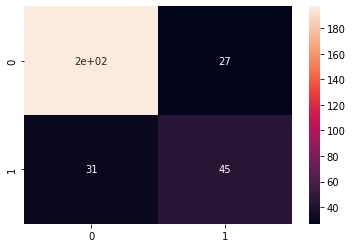

In [59]:
rf2 = RandomForestClassifier(n_estimators=500,min_samples_split=400,min_samples_leaf=1,max_features='auto'
                            ,max_depth=None,bootstrap='False')
rf2.fit(X_train, y_train)

preds = rf2.predict(X_test)

score = rf2.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

25.333333333333336

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       224
           1       0.25      1.00      0.40        76

    accuracy                           0.25       300
   macro avg       0.13      0.50      0.20       300
weighted avg       0.06      0.25      0.10       300



C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

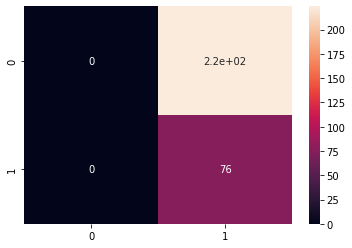

In [64]:
from sklearn.naive_bayes import GaussianNB

gaus = GaussianNB()
gaus.fit(X_train, y_train)

preds = gaus.predict(X_test)

score = gaus.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

76.33333333333333

              precision    recall  f1-score   support

           0       0.96      0.71      0.82       224
           1       0.52      0.92      0.66        76

    accuracy                           0.76       300
   macro avg       0.74      0.82      0.74       300
weighted avg       0.85      0.76      0.78       300



C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<AxesSubplot:>

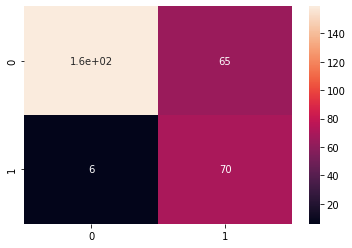

In [68]:
from sklearn import svm

clf = svm.LinearSVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

83.66666666666667

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       224
           1       0.62      0.91      0.74        76

    accuracy                           0.84       300
   macro avg       0.79      0.86      0.81       300
weighted avg       0.88      0.84      0.85       300



<AxesSubplot:>

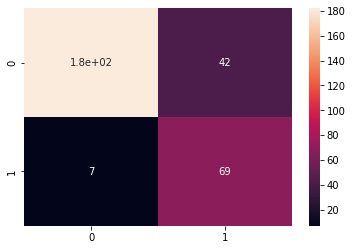

In [83]:
from sklearn import svm

clf2 = svm.LinearSVC(penalty='l1', dual=False, random_state=13)

#loss='squared_hinge', *, dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)

clf2.fit(X_train, y_train)
preds = clf2.predict(X_test)
score = clf2.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

In [102]:
#from sklearn.model_selection import RandomizedSearchCV
penalty=['l1','l2']
loss=['squared_hinge','hinge']
dual=[True,False]
#tol=[float(x) for x in np.linspace(start = 0.00001, stop = 0.001, num = 0.00001)]
C=[float(x) for x in np.linspace(start = 1, stop = 10, num = 1)]
multi_class=['ovr', 'crammer_singer']
fit_intercept=[True,False]
intercept_scaling=[int(x) for x in np.linspace(start = 1, stop = 100, num = 3)]
#max_iter=500

random_grid = {'penalty': penalty,
               'loss': loss,
               'dual': dual,
               #'tol': tol,
               'C': C,
               'multi_class': multi_class,
               'fit_intercept': fit_intercept,
               'intercept_scaling': intercept_scaling,
               #'max_iter':max_iter
              }

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = svm.LinearSVC(), param_distributions = random_grid, n_iter = 100, cv = 5, verbose=3, random_state=13, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 96 candidates, totalling 480 fits


C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py", line

RandomizedSearchCV(cv=5, estimator=LinearSVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1.0], 'dual': [True, False],
                                        'fit_intercept': [True, False],
                                        'intercept_scaling': [1, 50, 100],
                                        'loss': ['squared_hinge', 'hinge'],
                                        'multi_class': ['ovr',
                                                        'crammer_singer'],
                                        'penalty': ['l1', 'l2']},
                   random_state=13, verbose=3)

In [103]:
rf_random.best_params_

{'penalty': 'l2',
 'multi_class': 'ovr',
 'loss': 'squared_hinge',
 'intercept_scaling': 50,
 'fit_intercept': True,
 'dual': True,
 'C': 1.0}

79.33333333333333

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       224
           1       0.85      0.22      0.35        76

    accuracy                           0.79       300
   macro avg       0.82      0.61      0.62       300
weighted avg       0.80      0.79      0.74       300



C:\Users\kemal\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<AxesSubplot:>

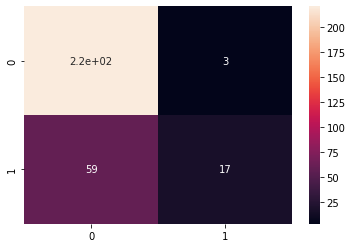

In [105]:
from sklearn import svm

clf2 = svm.LinearSVC(penalty='l2',multi_class='ovr',loss='squared_hinge',intercept_scaling=50,fit_intercept=True,dual=True,C=1.0,random_state=13)

#loss='squared_hinge', *, dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)

clf2.fit(X_train, y_train)
preds = clf2.predict(X_test)
score = clf2.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)